In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split

In [85]:
ratings = pd.read_csv('./ml-1m/ratings.dat', names = ['userId','movieId','rating','timestamp'], delimiter='::')
movies = pd.read_csv('./ml-1m/movies.dat', names = ['movieId','title','genres'], delimiter='::')

/home/arsen/anaconda3/envs/ng_fd/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/home/arsen/anaconda3/envs/ng_fd/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [86]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [87]:
movies.head()

,movieID,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [258]:
ratings.movieId.nunique(), ratings.userId.nunique()

(3706, 6040)

In [259]:
ratings.shape, movies.shape

((1000209, 4), (3676, 6))

In [94]:
train, test = train_test_split(ratings, test_size = 0.2, random_state=15)

In [95]:
train.shape, test.shape

((800167, 4), (200042, 4))

In [96]:
N_users = train.userId.nunique()
N_movies = train.movieId.nunique()
N_users, N_movies

(6040, 3676)

In [97]:
test = test[test.movieId.isin(train.movieId.unique())]
test.shape

(200008, 4)

In [98]:
N_factors = 50
user_factors = np.random.randn(N_users, N_factors)
movie_factors = np.random.randn(N_movies, N_factors)

In [99]:
movie_enum_dict = {k : v for v, k in enumerate(train.movieId.unique())}
user_enum_dict = {k : v for v, k in enumerate(ratings.userId.unique())}

train['movieEnum'] = train.movieId.map(movie_enum_dict)
train['userEnum'] = train.userId.map(user_enum_dict)

test['movieEnum'] = test.movieId.map(movie_enum_dict)
test['userEnum'] = test.userId.map(user_enum_dict)

/home/arsen/anaconda3/envs/ng_fd/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/arsen/anaconda3/envs/ng_fd/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [100]:
train.rating.mean()

3.5819935088550263

In [101]:
X_train = np.array(train[['userEnum','movieEnum']], dtype = np.int16)
y_train = np.array(train.rating) - 3.5

X_test = np.array(test[['userEnum','movieEnum']], dtype = np.int16)
y_test = np.array(test.rating) - 3.5
X_train.shape, X_test.shape

((800167, 2), (200008, 2))

In [102]:
def rmse(data, labels):
    preds = np.einsum('ij,ij->i',user_factors[data[:,0]], movie_factors[data[:,1]])
    return np.mean((labels - preds)**2)

def sgd_generator(data, labels):
    for i in np.random.permutation(np.arange(len(data))):
        yield data[i], labels[i]

In [103]:
N_epochs = 50
lr = 0.01
reg = 0.1
for epoch in tqdm(range(N_epochs)):
    for (user_ix, movie_ix), rating_i in sgd_generator(X_train, y_train):
        user_i = user_factors[user_ix]
        movie_i = movie_factors[movie_ix]
        pred = np.dot(user_factors[user_ix], movie_factors[movie_ix])
        pred_err = rating_i - pred
        
        user_factors[user_ix] = user_factors[user_ix] + lr * (pred_err*movie_factors[movie_ix] - reg*user_factors[user_ix])
        movie_factors[movie_ix] = movie_factors[movie_ix] + lr * (pred_err*user_factors[user_ix] - reg*movie_factors[movie_ix])
        
    if (epoch+1) % 5 ==0:
        print ('train rmse: {:.3f}, test rmse: {:.3f}'.format(rmse(X_train, y_train), rmse(X_test, y_test)))

 10%|█         | 5/50 [00:45<06:56,  9.26s/it]

train rmse: 0.774, test rmse: 1.272


 20%|██        | 10/50 [01:33<06:23,  9.58s/it]

train rmse: 0.698, test rmse: 0.969


 30%|███       | 15/50 [02:21<05:36,  9.61s/it]

train rmse: 0.683, test rmse: 0.881


 40%|████      | 20/50 [03:08<04:44,  9.47s/it]

train rmse: 0.673, test rmse: 0.839


 50%|█████     | 25/50 [03:56<03:59,  9.59s/it]

train rmse: 0.665, test rmse: 0.816


 60%|██████    | 30/50 [04:44<03:11,  9.58s/it]

train rmse: 0.659, test rmse: 0.800


 70%|███████   | 35/50 [05:30<02:19,  9.27s/it]

train rmse: 0.654, test rmse: 0.789


 80%|████████  | 40/50 [06:15<01:31,  9.15s/it]

train rmse: 0.650, test rmse: 0.783


 90%|█████████ | 45/50 [07:01<00:45,  9.15s/it]

train rmse: 0.647, test rmse: 0.777


100%|██████████| 50/50 [07:47<00:00,  9.43s/it]

train rmse: 0.643, test rmse: 0.773


In [104]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

X = movie_factors
distorsions = []
for k in tqdm(range(2, 50, 2)):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

100%|██████████| 24/24 [00:10<00:00,  1.50it/s]


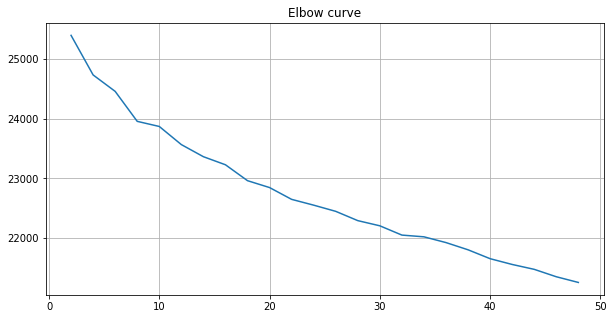

In [105]:
fig = plt.figure(figsize=(10, 5))
plt.plot(range(2, 50, 2), distorsions)
plt.grid(True)
plt.title('Elbow curve')
plt.show()

In [165]:
kmeans = KMeans(n_clusters=10, random_state=7)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=7, tol=0.0001, verbose=0)

In [166]:
clusts = kmeans.predict(X)

In [167]:
Counter(clusts)

Counter({0: 1248,
         5: 1258,
         2: 738,
         3: 105,
         1: 84,
         9: 94,
         4: 89,
         7: 58,
         6: 1,
         8: 1})

In [170]:
clusts_dict = {movie_enum : cluster for movie_enum, cluster in enumerate(clusts)}

In [171]:
movies = movies[movies.movieId.isin(train.movieId.unique())]
movies.shape

(3676, 6)

In [173]:
movies['movieEnum'] = movies.movieId.map(movie_enum_dict)
movies['clusts'] = movies.movieEnum.map(clusts_dict)

In [175]:
genres = [i.split('|') for i in movies.genres.values]
genres_counter = Counter([j for i in genres for j in i])

In [176]:
sorted(genres_counter.items(), key=lambda x:x[1], reverse=True)

[('Drama', 1477),
 ('Comedy', 1157),
 ('Action', 494),
 ('Thriller', 481),
 ('Romance', 457),
 ('Horror', 339),
 ('Adventure', 278),
 ('Sci-Fi', 273),
 ("Children's", 250),
 ('Crime', 200),
 ('War', 141),
 ('Musical', 112),
 ('Documentary', 107),
 ('Animation', 105),
 ('Mystery', 103),
 ('Fantasy', 68),
 ('Western', 66),
 ('Film-Noir', 44)]

In [178]:
def get_genres_for_clust(clust_num):
    clust_genres = [i.split('|') for i in movies[movies.clusts==clust_num].genres.values]
    clust_genres_flattened = [j for i in clust_genres for j in i]
    clusts_counter = Counter(clust_genres_flattened)
    return sorted(clusts_counter.items(), key = lambda x: x[1], reverse = True)

In [179]:
for i in range(len(set(clusts))):
    print ('cluster: {}, top genres: {}'.format(i, get_genres_for_clust(i)[:5]))

cluster: 0, top genres: [('Drama', 649), ('Comedy', 339), ('Romance', 156), ('Thriller', 139), ('Action', 96)]
cluster: 1, top genres: [('Drama', 51), ('Comedy', 28), ('Romance', 8), ('Crime', 6), ('Horror', 6)]
cluster: 2, top genres: [('Comedy', 288), ('Action', 163), ('Horror', 156), ('Drama', 118), ('Thriller', 111)]
cluster: 3, top genres: [('Drama', 53), ('Comedy', 23), ('Documentary', 12), ('Romance', 10), ('Horror', 7)]
cluster: 4, top genres: [('Drama', 48), ('Comedy', 23), ('Thriller', 9), ('Romance', 6), ('Action', 5)]
cluster: 5, top genres: [('Drama', 482), ('Comedy', 416), ('Action', 213), ('Romance', 204), ('Thriller', 201)]
cluster: 6, top genres: [('Drama', 1)]
cluster: 7, top genres: [('Drama', 27), ('Comedy', 15), ('Romance', 7), ('Action', 6), ('Documentary', 5)]
cluster: 8, top genres: [('Comedy', 1), ('Drama', 1), ('Western', 1)]
cluster: 9, top genres: [('Drama', 47), ('Comedy', 24), ('Thriller', 9), ('Documentary', 8), ('Horror', 8)]


In [211]:
def closest_movies_to(movie_name):
    movie_enum = movies[movies.title==movie_name]
    if len(movie_enum) == 0: return 'No such movie found'
    ix = movie_enum.movieEnum.iloc[0]
    norms = np.linalg.norm(movie_factors - movie_factors[ix], axis=1)
    return movies[movies.movieEnum.isin(np.argsort(norms)[1:4])]

In [212]:
closest_movies_to('Heat (1995)')

,movieID,title,genres,movieId,movieEnum,clusts
427,431,Carlito's Way (1993),Crime|Drama,431,2110,0
1439,1466,Donnie Brasco (1997),Crime|Drama,1466,587,0
3100,3169,"Falcon and the Snowman, The (1984)",Drama,3169,1105,0


In [213]:
closest_movies_to('Nightmare on Elm Street 4: The Dream Master, A (1988)')

,movieID,title,genres,movieId,movieEnum,clusts
1901,1970,"Nightmare on Elm Street 3: Dream Warriors, A (...",Horror,1970,2243,2
1903,1972,"Nightmare on Elm Street 5: The Dream Child, A ...",Horror,1972,1720,2
1904,1973,Freddy's Dead: The Final Nightmare (1991),Horror,1973,718,2


In [217]:
closest_movies_to('Great Mouse Detective, The (1986)')

,movieID,title,genres,movieId,movieEnum,clusts
2009,2078,"Jungle Book, The (1967)",Animation|Children's|Comedy|Musical,2078,946,0
2018,2087,Peter Pan (1953),Animation|Children's|Fantasy|Musical,2087,830,0
2021,2090,"Rescuers, The (1977)",Animation|Children's,2090,569,5


In [270]:
some_factor_vector = np.zeros(50)
some_factor_vector[30] = 10

In [271]:
norms = np.linalg.norm(movie_factors - some_factor_vector, axis=1)
movies[movies.movieEnum.isin(np.argsort(norms)[:10])]

,movieID,title,genres,movieId,movieEnum,clusts
53,54,"Big Green, The (1995)",Children's|Comedy,54,3234,2
443,447,"Favor, The (1994)",Comedy|Romance,447,2765,2
864,875,Nothing to Lose (1994),Drama,875,2704,5
1521,1561,Wedding Bell Blues (1996),Comedy,1561,2515,4
2110,2179,Topaz (1969),Thriller,2179,1645,5
2768,2837,Bedrooms & Hallways (1998),Comedy|Romance,2837,3447,0
2989,3058,"Ape, The (1940)",Horror|Sci-Fi,3058,3350,2
3685,3754,"Adventures of Rocky and Bullwinkle, The (2000)",Animation|Children's|Comedy,3754,98,2
3778,3848,Silent Fall (1994),Drama|Thriller,3848,3303,9
3813,3883,Catfish in Black Bean Sauce (2000),Comedy|Drama,3883,2997,4


In [274]:
some_factor_vector = np.zeros(50)
some_factor_vector[35] = 10

In [275]:
norms = np.linalg.norm(movie_factors - some_factor_vector, axis=1)
movies[movies.movieEnum.isin(np.argsort(norms)[:10])]

,movieID,title,genres,movieId,movieEnum,clusts
82,83,Once Upon a Time... When We Were Colored (1995),Drama,83,2639,0
146,148,"Awfully Big Adventure, An (1995)",Drama,148,2976,5
813,824,Kaspar Hauser (1993),Drama,824,163,0
1049,1063,Johns (1996),Drama,1063,2156,5
1555,1596,Career Girls (1997),Drama,1596,3176,0
1803,1872,Go Now (1995),Drama,1872,3122,4
2510,2579,Following (1998),Drama,2579,1587,0
2620,2689,Get Bruce (1999),Documentary,2689,3308,5
3563,3632,Monsieur Verdoux (1947),Comedy,3632,2135,0
3703,3772,Hatchet For the Honeymoon (Rosso Segno Della F...,Horror,3772,3660,7
